In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib notebook
from main import *

In [2]:
#Extracting the SS coverages previously saved and extracted from kMC files
ss_COVG_NONLAT = pd.read_csv('SS_Covg_nonLat.csv')
ss_COVG_LAT = pd.read_csv('SS_Covg_Lat.csv')

In [3]:
#Isolating pressures and ss coverages
Prs_non_lat = ss_COVG_NONLAT.iloc[:,0].to_numpy()
Prs_lat = ss_COVG_LAT.iloc[:,0].to_numpy()
ss_covg_non_lat = ss_COVG_NONLAT.iloc[:,1].to_numpy()
ss_covg_lat = ss_COVG_LAT.iloc[:,1].to_numpy()

In [4]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [5]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 2.65 s, sys: 8.95 ms, total: 2.66 s
Wall time: 2.67 s


<IPython.core.display.Javascript object>


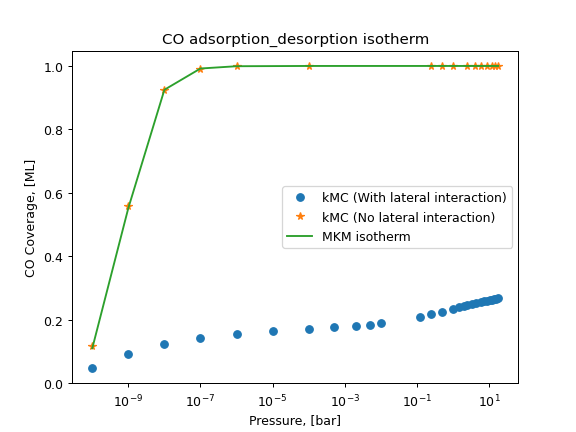

In [6]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

## Trying to model the lateral interactions

In [7]:
%%time
#Performing SS MIKI MKM simulations for lateral case
from main import *
MKMCD = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKMCD.Thermo_Constraint = 'OFF'
MKMCD.set_limits_of_integration(t0,tf)
MKMCD.rate_const_correction='Forced_exp_CD'
colmn = len(MKMCD.Stoich.iloc[0,1:]) - len(MKMCD.P) #Number of columns (i.e rate coefficients = no. of surface species being investigated)
row = len(MKMCD.k) #number of rows = number of rate constants (i.e reaction steps)
coef =np.array([5e-5,5e-3,1,1]) #fwd1,rvs1;fwd2,rvs2...
MKMCD.Coeff = coef.reshape(row,colmn) 
MKM_SS_covg_LAT = []
Prs = Prs_lat #Lateral pressures
for i in np.arange(len(Prs)):
    MKMCD.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKMCD.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 4.57 s, sys: 15.5 ms, total: 4.59 s
Wall time: 4.59 s


<IPython.core.display.Javascript object>


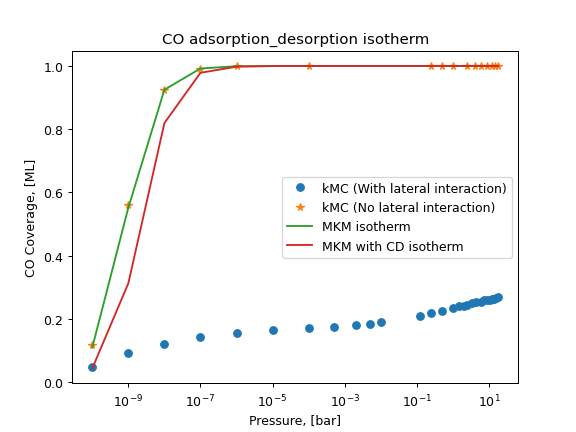

In [8]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
plt.semilogx(Prs_lat,MKM_SS_covg_LAT,'-',label='MKM with CD isotherm')

# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

### Fitting BG COEFFS

In [9]:
#FITTING BG COEFFs
def MKModelling_Press(*coeff):
    MKMCD = MKModel('Atomic.csv','Stoich.csv','Param.csv')
    MKMCD.Thermo_Constraint = 'OFF'
    MKMCD.set_limits_of_integration(t0,tf)
    MKMCD.rate_const_correction='Forced_exp_CD'
    colmn = len(MKMCD.Stoich.iloc[0,1:]) - len(MKMCD.P) #Number of columns (i.e rate coefficients = no. of surface species being investigated)
    row = len(MKMCD.k) #number of rows = number of rate constants (i.e reaction steps)
    coef = np.array(coeff) #np.array([5e-5,5e-3,1,1]) #fwd1,rvs1;fwd2,rvs2...
    MKMCD.Coeff = coef.reshape(row,colmn) 
    MKM_SS_covg_LAT = []
    Prs = Prs_lat #Lateral pressures
    for i in np.arange(len(Prs)):
        MKMCD.set_rxnconditions(Pr=[Prs[i]])
        MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKMCD.get_SS_coverages(print_warning=False)[0])
        
    return MKM_SS_covg_LAT

In [10]:
%%time
### Fitting rate constant function due to the feature = iRates
def MKM_k_fitting(x,*coeff):
    data_sscovg_MKM_lat  = MKModelling_Press(*coeff)    
    return np.reshape(data_sscovg_MKM_lat,data_sscovg_MKM_lat.size)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [11]:
%%time
x_values = Prs_lat
y_values = np.reshape(ss_covg_lat,ss_covg_lat.size) #Normalized Input Dependent variable(s) (eg. KMC coverages)

initial_vals = np.array([-10,-8,10,10])

params, params_covariance = optimize.curve_fit(MKM_k_fitting, x_values, y_values
                                            ,method = 'trf', bounds=([-20., -20., 10 , 8], [-10, -8, 20, 20]), maxfev=1e3, xtol=1e-8, ftol=1e-8
                                            ,p0=initial_vals)

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conse

In [12]:
params

array([-20.        ,  -8.28585647,  20.        ,   8.37387365])

In [13]:
%%time
#Performing SS MIKI MKM simulations for lateral case
from main import *
MKMCD = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKMCD.Thermo_Constraint = 'OFF'
MKMCD.set_limits_of_integration(t0,tf)
MKMCD.rate_const_correction='Forced_exp_CD'
colmn = len(MKMCD.Stoich.iloc[0,1:]) - len(MKMCD.P) #Number of columns (i.e rate coefficients = no. of surface species being investigated)
row = len(MKMCD.k) #number of rows = number of rate constants (i.e reaction steps)
coef = params #fwd1,rvs1;fwd2,rvs2...
MKMCD.Coeff = coef.reshape(row,colmn) 
MKM_SS_covg_LAT = []
Prs = Prs_lat #Lateral pressures
for i in np.arange(len(Prs)):
    MKMCD.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKMCD.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 6.42 s, sys: 19.4 ms, total: 6.44 s
Wall time: 6.46 s


<IPython.core.display.Javascript object>


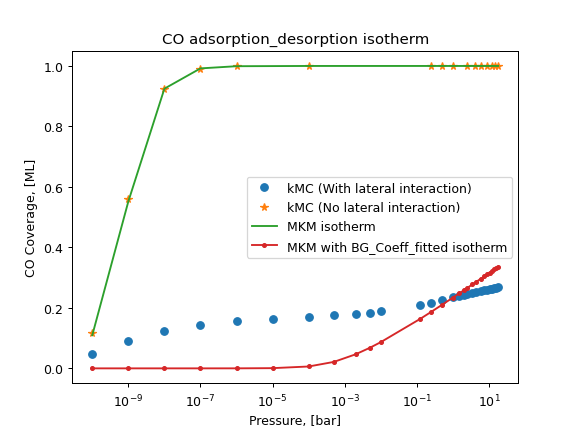

In [16]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
plt.semilogx(Prs_lat,MKM_SS_covg_LAT,'.-',label='MKM with BG_Coeff_fitted isotherm')

# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

<IPython.core.display.Javascript object>


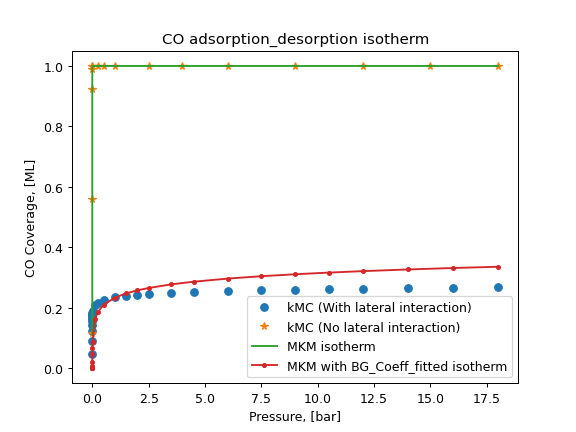

In [17]:
plt.figure()
plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.plot(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
plt.plot(Prs_lat,MKM_SS_covg_LAT,'.-',label='MKM with BG_Coeff_fitted isotherm')

# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

[mpf('18.0')]